# Vecteurs de mot
# 03/12/2021
# @author : jeremylhour

In [74]:
import numpy as np
import matplotlib.pyplot as plt

import fasttext.util
from sklearn.decomposition import TruncatedSVD

In [75]:
# Définition des fonctions utiles

def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    print(f"Running Truncated SVD over {len(M)} words...")
    svd = TruncatedSVD(n_components=2, n_iter=10, random_state=42)
    svd.fit(M)
    M_reduced = svd.transform(M)
    print("Done.")
    return M_reduced

def plot_embeddings(M_reduced, word2ind, words, path):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
            path (str): where to save
    """
    points = M_reduced[[word2ind[word] for word in words],]
    fig, ax = plt.subplots()
    ax.scatter(points[:,0], points[:,1])

    for i, txt in enumerate(words):
        ax.annotate(txt, (points[i,0], points[i,1]))
        
    for i in range(0, len(points), 2):
        ax.plot(points[i:(i+2),0], points[i:(i+2),1], 'ro--')
    ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    fig.savefig(path, dpi=300)

In [76]:
# Chargement du modèle avec des vecteurs de taille 100
ft = fasttext.load_model('fastText/cc.fr.300.bin')

Running Truncated SVD over 16 words...
Done.


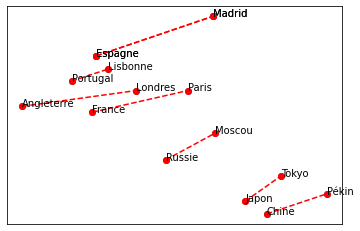

In [77]:
# Pays et capitales

liste_de_mots = [
    'France', 'Paris',
    'Espagne', 'Madrid',
    'Angleterre', 'Londres',
    'Espagne', 'Madrid',
    'Portugal', 'Lisbonne',
    'Japon', 'Tokyo',
    'Chine', 'Pékin',
    'Russie', 'Moscou',
                ]
word2ind = dict(zip(liste_de_mots, [i for i in range(len(liste_de_mots))]))


M = np.array([ft.get_word_vector(liste_de_mots[i]) for i in range(len(liste_de_mots))])
    
M_reduced = reduce_to_k_dim(M, k=2)
plot_embeddings(M_reduced, word2ind, liste_de_mots, 'imgs/capitals.png')

Running Truncated SVD over 18 words...
Done.


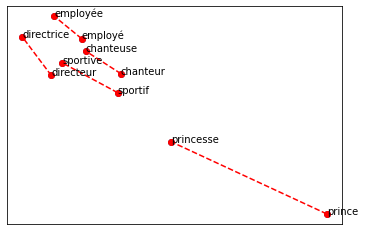

In [10]:
# féminin et masculin
liste_de_mots = [
    'chanteur', 'chanteuse',
    'prince', 'princesse',
    'directeur', 'directrice',
    'sportif', 'sportive',
    'employé', 'employée',
    'musicien', 'musicienne',
    'lui', 'elle',
    'heureux', 'heureuse',
    'roi', 'reine',
                ]
word2ind = dict(zip(liste_de_mots, [i for i in range(len(liste_de_mots))]))
M = np.array([ft.get_word_vector(mot) for mot in liste_de_mots])
M_reduced = reduce_to_k_dim(M, k=2)
plot_embeddings(M_reduced, word2ind, liste_de_mots[:10], 'imgs/feminin_masculin.png')

In [103]:
# Définition de la fonction pour projeter un vecteur sur p axes

def projection(X, y):
    """
    @param X (np.array): shape (n, p)
    @param y (np.array): shape n
    """
    
    X_plus_intercept = np.c_[ np.ones(len(X)), X]
    beta = np.linalg.inv(np.transpose(X_plus_intercept) @ X_plus_intercept) @ np.transpose(X_plus_intercept) @ y
    return beta[1:].tolist()

def _L2norm(vec):
    """
    _L2norm:
        computes L2 norm for vector or each rows of matrix
        
    @param vec (np.array): np.array of shape  (n_dim) or (n_vectors, n_dim) 
    """
    if vec.ndim == 1:
        return np.sqrt(np.sum(vec**2))
    else:
        return np.sqrt(np.sum(vec**2, axis=1))
    
def _cosineSimilarity(target_vec, vectors):
    """
    _cosineSimilarity:
        computes cosine similarity between the target_vec and all other vectors in vectors
        
    @param target_vec (np.array): vector of shape n_dim
    @param vectors (np.array): np.array of shape (n_vectors, n_dim) 
    """
    metric = vectors @ target_vec / (_L2norm(vectors) * _L2norm(target_vec))
    return metric.tolist()

def plot_on_axes(model, X, words, path, mode='cosine'):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            model (fastText model):
            X (np.array): where to project
            words (list of strings): words whose embeddings we want to visualize
            path (str): where to save
    """
    if mode=='cosine':
        points = np.array([_cosineSimilarity(model.get_word_vector(mot), np.transpose(X)) for mot in words])
    else:
        points = np.array([projection(X, model.get_word_vector(mot)) for mot in words])
        
    fig, ax = plt.subplots()
    ax.axhline(y=0, color='b', linestyle='--')
    ax.axvline(x=0, color='b', linestyle='--')
    ax.scatter(points[:,0], points[:,1])

    for i, txt in enumerate(words):
        ax.annotate(txt, (points[i,0], points[i,1]))
        
    ax.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
    fig.savefig(path, dpi=300)

In [104]:
# Definition des axes de genres et de classe sociale
liste_genre = [
    'homme', 'femme',
    'hommes', 'femmes',
    'garçon', 'fille',
    'garçons', 'filles',
    'lui', 'elle',
    'il', 'elle',
    'masculin', 'féminin',
    'mâle', 'femelle'
]

axe_genre = 0
sign = 1
for mot in liste_genre:
    axe_genre += ft.get_word_vector(mot)*sign
    sign *= -1

liste_classe_sociale = [
    'riche', 'pauvre',
    'richesse', 'pauvreté',
    'luxe', 'dénuement',
    'cher', 'bon marché',
    'abondance', 'manque',
    'opulence', 'besoin',
    'prospérité', 'misère'
]

axe_classe = 0
sign = 1
for mot in liste_classe_sociale:
    axe_classe += ft.get_word_vector(mot)*sign
    sign *= -1



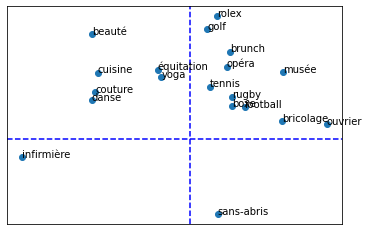

In [105]:
liste_activites = [
    'football', 'rugby',
    'boxe', 'danse', 'yoga',
    'golf', 'équitation', 'couture',
    'tennis', 'opéra',
    'musée', 'cuisine', 'bricolage',
    'brunch', 'beauté', 'rolex',
    'ouvrier', 'infirmière', 'sans-abris'
]

X = np.c_[axe_genre, axe_classe]
plot_on_axes(ft, np.c_[axe_genre, axe_classe], liste_activites, 'imgs/projections.png')